## Pandas For Finance

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
#For updating pandas_datareader
#!pip install --upgrade pandas_datareader
#!pip install --upgrade scipy --user

import seaborn as sb


import datetime as dt
from pandas_datareader import data as pdr

import yfinance as yfin
yfin.pdr_override()

from scipy.stats import norm, t

### Stock Selection and Time Period 
We will use yahoo finance to import stock data into Pandas dataframe


In [2]:
# Stock list
stockList = ['FLT', 'HLO', 'QAN', 'VAS', 'WEB']
stocks = [stock+'.AX' for stock in stockList] #Yahoo finance requires .AX for ASX
print(stocks)

# Time period
end = dt.datetime.now()
start =end - dt.timedelta(days=1000)





['FLT.AX', 'HLO.AX', 'QAN.AX', 'VAS.AX', 'WEB.AX']


### Importing Data and Portfolio Performance metrics

#### Useful formulas
Portfolio volatility of N stocks
$$\sigma_{p} = \sqrt{W_T * \Sigma * W}$$
Where 
$W$ is a row vector of weights, and T is the transpose 

$*$ is the dot product operation



In [18]:
def importData(stocks, start, end):
    rawData = pdr.get_data_yahoo(stocks, start=start, end=end)
    
    # Data Cleaning and setting date as index
    rawData.dropna() #Remove any missing values
    
    # In Jupyter notebook, it is advised to not change the date format
    # Date data is already styled in yyyy-mm-dd
    
    # Setting Date as index
    # by default, date is already the index
    # rawData.index will tell what is the index
    # Also means we dont need to specify the date column when plotting
    
    cleanData = rawData
    return cleanData





# Portfolio performance metrics
# Time is in units of days
# Weights needs to be a row vector # Weights generator is housed in this function
def portPerform(cleanData, Time):

    adjclose = cleanData['Adj Close']
    
    returns = adjclose.pct_change()
     # .pct_change() Computes the fractional change from the immediately previous row by default.
    returns = returns.dropna()

    # Randomly Generate Weights
    weights = np.random.random(len(returns.columns))
    weights /= np.sum(weights)
    
    meanReturns = returns.mean()
    # .mean() Return the mean of the values over the requested axis.
    
    covMatrix = returns.cov()
    # Compute pairwise covariance of columns, excluding NA/null values.
    
    # Weighted Returns for a time period
    # This is the expected return for the portfolio in a time period
    returnsWeight = np.sum(meanReturns*weights)*Time
    
    # Compute Standard Deviation
    # This is using vectorised formula
    sd = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    
    portReturn = returns.dot(weights) # Weighted daily returns
    
   
    
    return returns, sd, meanReturns, covMatrix, returnsWeight, portReturn
    
   
    

In [19]:

# Define arbitrary time period in days
Time = 100 


# Call importData function
cleanData = importData(stocks, start, end)

# Call portfolio performance function

returns, sd, meanReturns, covMatrix, returnsWeight, portReturn = portPerform( cleanData, Time)




[*********************100%%**********************]  5 of 5 completed


<function matplotlib.pyplot.show(*args, **kw)>

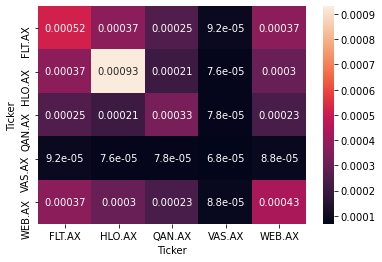

In [84]:
## Covariance heat map
np.bool = np.bool_ 
   #This is needed since np.bool was deprecated in Numpy
sb.heatmap(covMatrix,annot=True)
plt.show

## Correlation heat map
#sb.heatmap(returns.corr(method='pearson'))
#plt.show




<function matplotlib.pyplot.show(*args, **kw)>

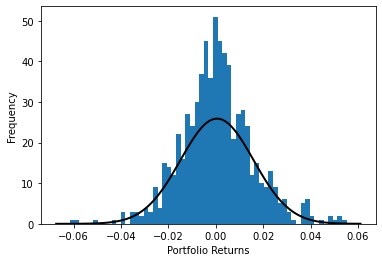

In [69]:
## Histogram of portfolio Returns

n_bins = 60

plt.hist(portReturn, bins=n_bins)
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")


mu, std = norm.fit(portReturn)
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
curve = norm.pdf(x,mu,std)
plt.plot(x, curve, 'k', linewidth=2)

plt.show

## Covariance heat map
#np.bool = np.bool_ 
#   This is needed since np.bool was deprecated in Numpy
#sb.heatmap(covMatrix)



## Correlation heat map
#sb.heatmap(returns.corr(method='pearson'))


<function matplotlib.pyplot.show(*args, **kw)>

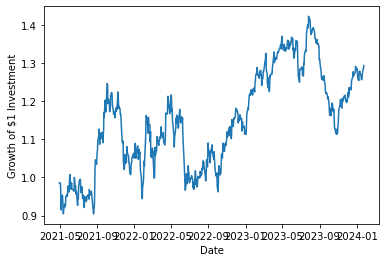

<Figure size 216x288 with 0 Axes>

In [33]:
# Growth of Portfolio

growth = (portReturn+1).cumprod()
plt.xlabel("Date")
plt.ylabel("Growth of $1 Investment")
plt.plot(growth)
plt.show

### Historical VaR
historical simulation does not assume a particular distribution of the asset returns

To do this we will define an arbitrary confidence level, usually an alpha of 5


In [47]:
def HVaR(portReturn, alpha):
    
    # Since our portReturn is only carries a column for returns and the index 
    # column of dates, we use the np.percentile function since the dataframe
    # is basically a Series
    return np.percentile(portReturn, alpha)

def HcVaR(portReturn, alpha):
    # expected return on the portfolio in the worst alpha% of cases
    # more sensitive to the shape of the tail of the loss distribution
    
    underVaR = portReturn <= HVaR(portReturn, alpha)
    # Create a new column of portReturns less than or equal to the
    return portReturn[underVaR].mean() 



Invest = 1

hVaR = -HVaR(portReturn, alpha=5)*np.sqrt(Time) #Value at Risk 95th CI
hCVaR = -HcVaR(portReturn, alpha=5)*np.sqrt(Time) #Conditional VaR 95th CI
Expected_portfolio_return = Invest*returnsWeight


### Parametric VaR

Now we make the assumption that possible outcomes are normally distributed about the mean

This is reasonable to expect since it is well documented that returns are roughly normally distributed and prices are lognormally distributed. However returns frequently deviate from what is considered 'normal' and have fat tails.

Therefore, it is advisable to perform some statistical tests such as a Jarque Bera Test to see if the skewness and kurtosis is from a normal distribution


#### Normal Distribution and t-distribution VaR

#### t dist
As the number of degrees of freedom grows, the t distribution approaches the normal distribution with mean 0 and variance 1.
its overall shape resembles the bell shape of a normally distributed variable with mean 0 and variance 1, except that it is a bit lower and wider.
Thus, we could use a t-distribution to account for the fatter tails

The variance of $t$ distributed random variable $T$ is,
$$\sigma = sd * \sqrt{\frac{(dof -2)}{dof}}$$
And 
$$X=\sigma T$$
Therefore, the VaR using the t-distribution is given by
$$sd * \sqrt{\frac{(dof -2)}{dof}}t^{-1}_{1-alpha}-\mu_{portfolio}$$

#### Conditional Parametric

#### Normal
When we are using the normal distribution
$$\sigma \frac{\phi (\Phi^{-1}(\alpha ))}{1-\alpha } -\mu_{portfolio}$$
Where $\phi$ is the standard normal p.d.f and $\Phi$ is the standard normal c.d.f



#### t dist
When we are using the t-distribution
$$\sigma \frac{(dof-2)+(T^{-1}(\alpha ))^{2}\tau (T^{-1}(\alpha ))}{(dof-2-1)\alpha } - \mu_{portfolio}$$
where $T(x)$ is the standard t-distribution c.d.f and $\tau$ is the standard t-distribution p.d.f



In [62]:

def p_VaR(portReturn,sd,alpha,dof,dist='normal' ):
    #Dist refers to what distribution is to be chosen
    # dof refers to degrees of freedom which is the number of stocks
    
    if dist =='normal':
        # norm.ppf() Returns a 95% significance interval for a one-tail test 
        # on a standard normal distribution
        VaR = norm.ppf(1-alpha/100)*sd - portReturn
    elif dist =='t-distribution':
        VaR = np.sqrt((dof-2)/dof)*t.ppf(1-alpha/100,dof)*sd - portReturn
    return VaR

def C_para_VaR(portReturn,sd,alpha,dof,dist='normal' ):
    
    if dist =='normal':
        CVaR = 1/(alpha/100) * norm.pdf(norm.ppf(alpha/100))*sd - portReturn
    
    elif dist =='t-distribution':
        tdist = t.ppf(alpha/100, dof)
        CVaR = -1/(alpha/100) * (1/(1-dof)) * (dof-2+tdist**2) * t.pdf(tdist,dof)*sd - portReturn


    
dof = len(stockList)    
alpha = 5

norm_VaR = p_VaR(portReturn,sd,alpha,dof,dist='normal' )
norm_c_VaR = C_para_VaR(portReturn,sd,alpha,dof,dist='normal')

t_VaR = p_VaR(portReturn,sd,alpha,dof,dist='t-distribution' )
t_c_VaR = C_para_VaR(portReturn,sd,alpha,dof,dist='t-distribution') 


    